# Edge AI Anomaly Detection

## Overview

This document contains the code for our EclipseCON 2022 Talk: "_How to Train Your Dragon and Its Friends: AI on the Edge with Eclipse Kura&trade;_"

In this notebook we'll cover:
- **Data collection**: how to retrieve training data from the field leveraging Eclipse Kura&trade; and Eclipse Kapua&trade;
- **Data processing**: how to explore our training data and manipulate them to make them suitable for training (feature selection, scaling and dataset splitting). This will provide us with the "_Preprocessing_" stage of the AI pipeline
- **Model training**: how we can create a simple Autoencoder in Keras and how to train it. This will provide us with the "_Inference_" stage of the AI pipeline
- **Model evaluation**: how can we extract the high level data from the model output and ensure the model was trained correctly. This will provide us with the "_Postprocessing_" stage of the AI pipeline
- **Model deployment**: how we can convert the model to make it suitable for running on Eclipse Kura&trade; and Nvidia Triton&trade; and deploy it on the edge.

---

## Data collection

### Cloud connection

After setting up an [Eclipse Kura&trade; instance on the Raspberry Pi](https://eclipse.github.io/kura/docs-develop/getting-started/raspberry-pi-raspberryos-quick-start/) we'll need to connect it to an [Eclipse Kapua&trade;](https://www.eclipse.org/kapua/) instance.

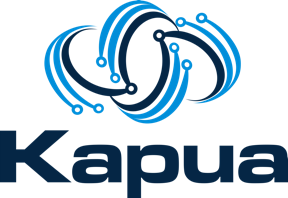

To do so you can refer to the [official Kura&trade; documentation](https://eclipse.github.io/kura/docs-develop/cloud-platform/kura-kapua/).

### Data publisher

To publish the collected data on the Cloud we'll need to create a new cloud publisher through the Kura&trade; web interface. Go to "Cloud connection" and press "New Pub/Sub", in the example below we'll call our new publisher `KapuaSenseHatPublisher`.

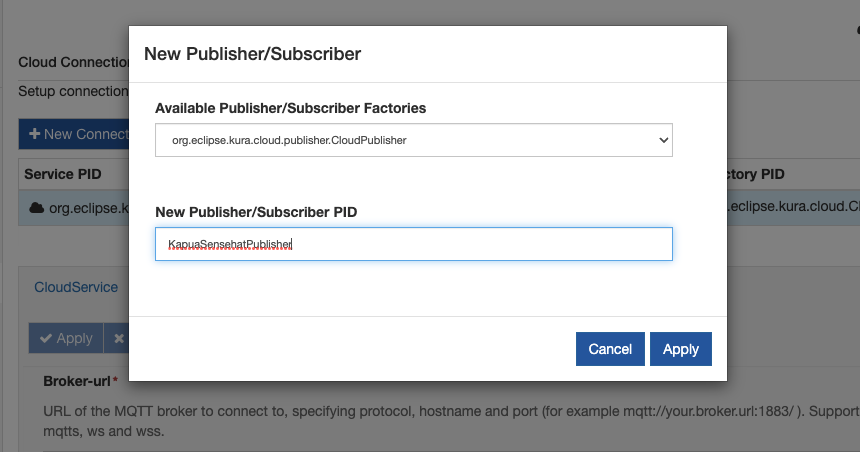

To keep things clean we'll create a new topic called `SenseHat`

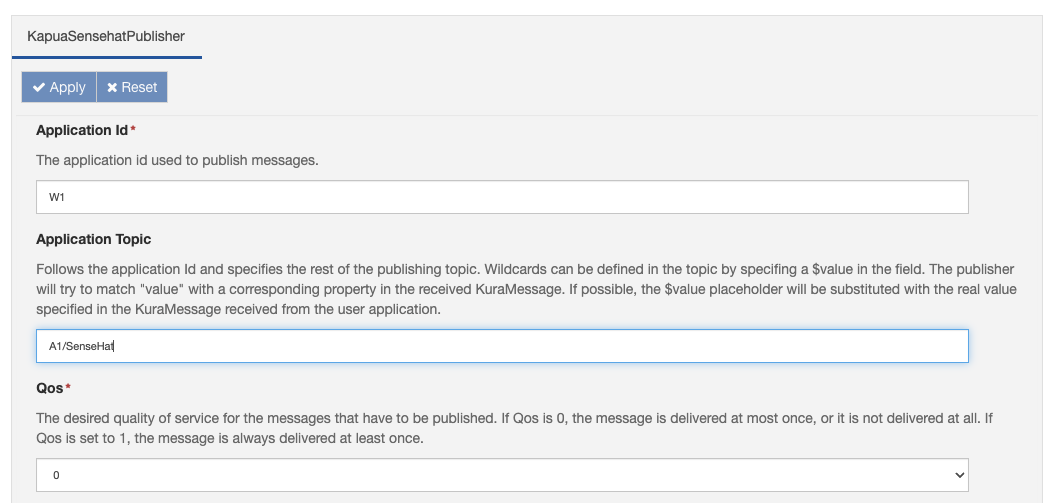

### SenseHat driver

Kura&trade; provides a driver that allows to interact to a RaspberryPi SenseHat device using [Kura Driver, Asset and Wires frameworks](https://eclipse.github.io/kura/docs-develop/connect-field-devices/driver-and-assets/).

Complete installation instructions are available [here](https://eclipse.github.io/kura/docs-develop/connect-field-devices/sensehat-driver/).

The driver requires:
- Configured SenseHat: see [SenseHat documentation](https://www.raspberrypi.com/documentation/accessories/sense-hat.html)
- I2C interface should be unlocked using `sudo raspi-config`

As the others Drivers supported by Kura, it is distributed as a deployment package on the Eclipse Marketplace [here](https://marketplace.eclipse.org/content/sensehat-example-driver-eclipse-kura-4xy).

It can be installed in the "Packages" section by simply dragging and dropping it from the Eclipse Marketplace.

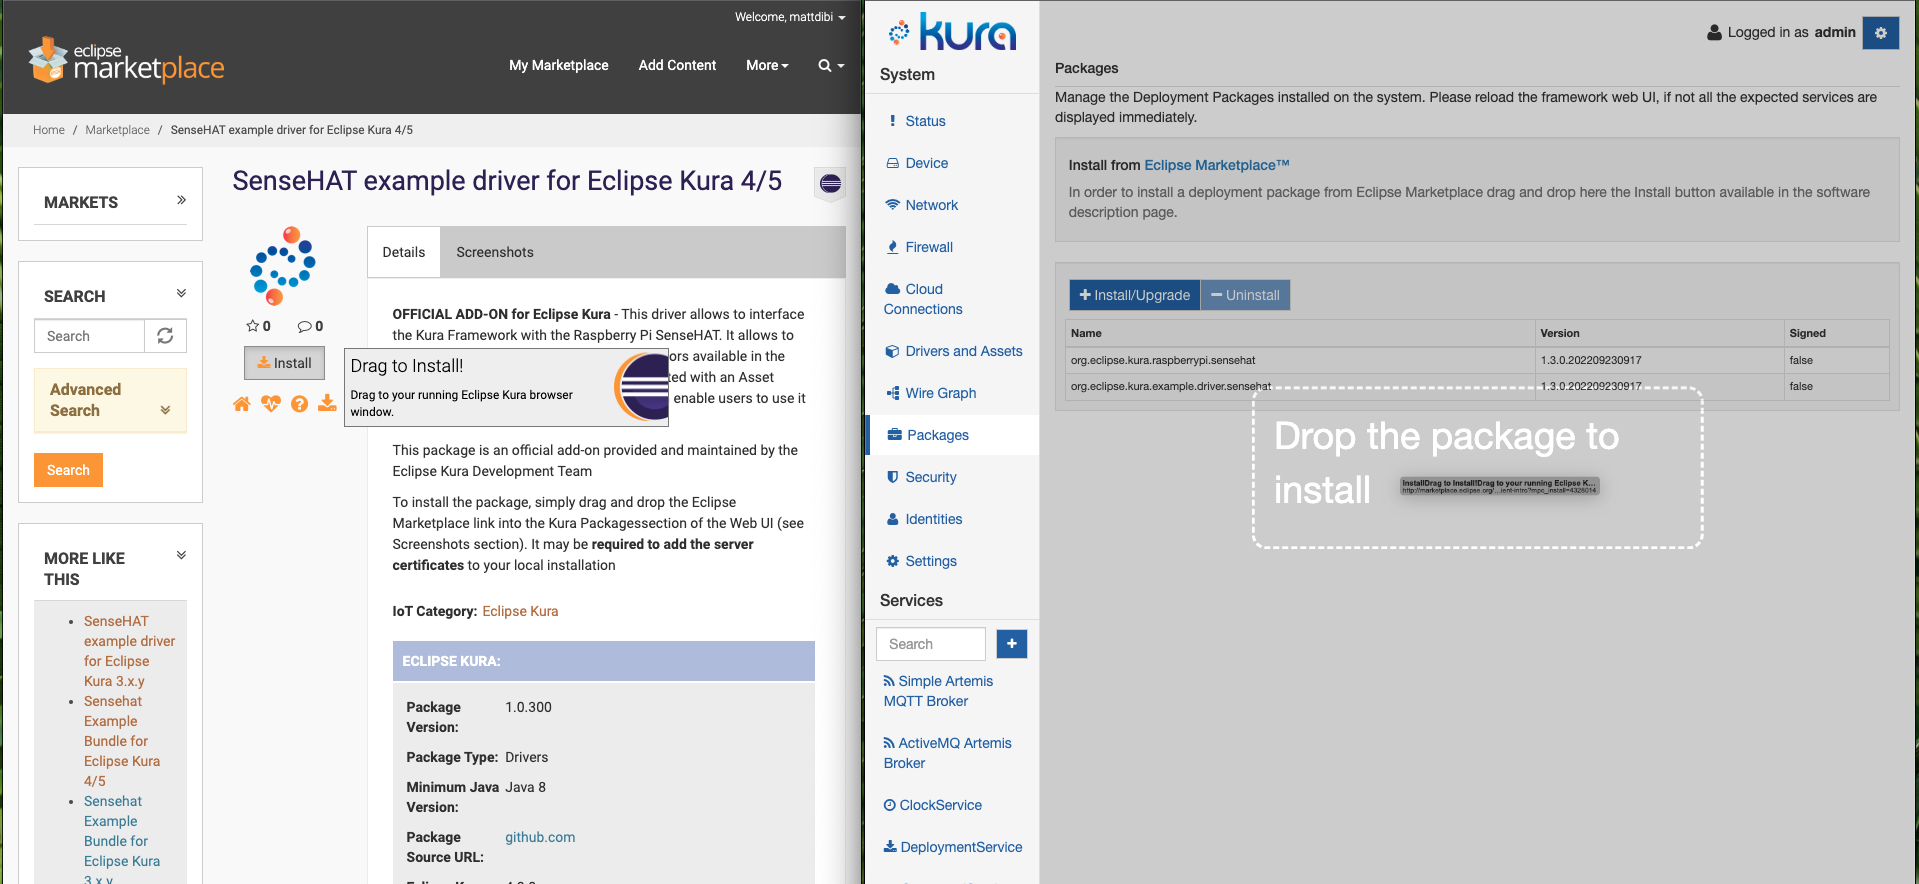

#### Driver configuration

We now need to configure the driver to access the sensors on the SenseHat. Move to the "Driver and Assets" section of the web UI and create a new driver.

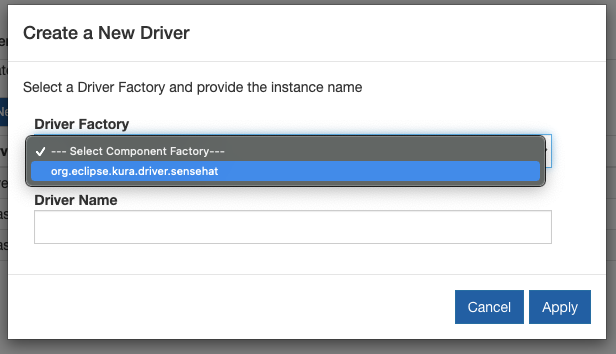

Then add a new asset to this driver and configure it as per the screenshots below, we'll need a channel for every sensor we want to access.

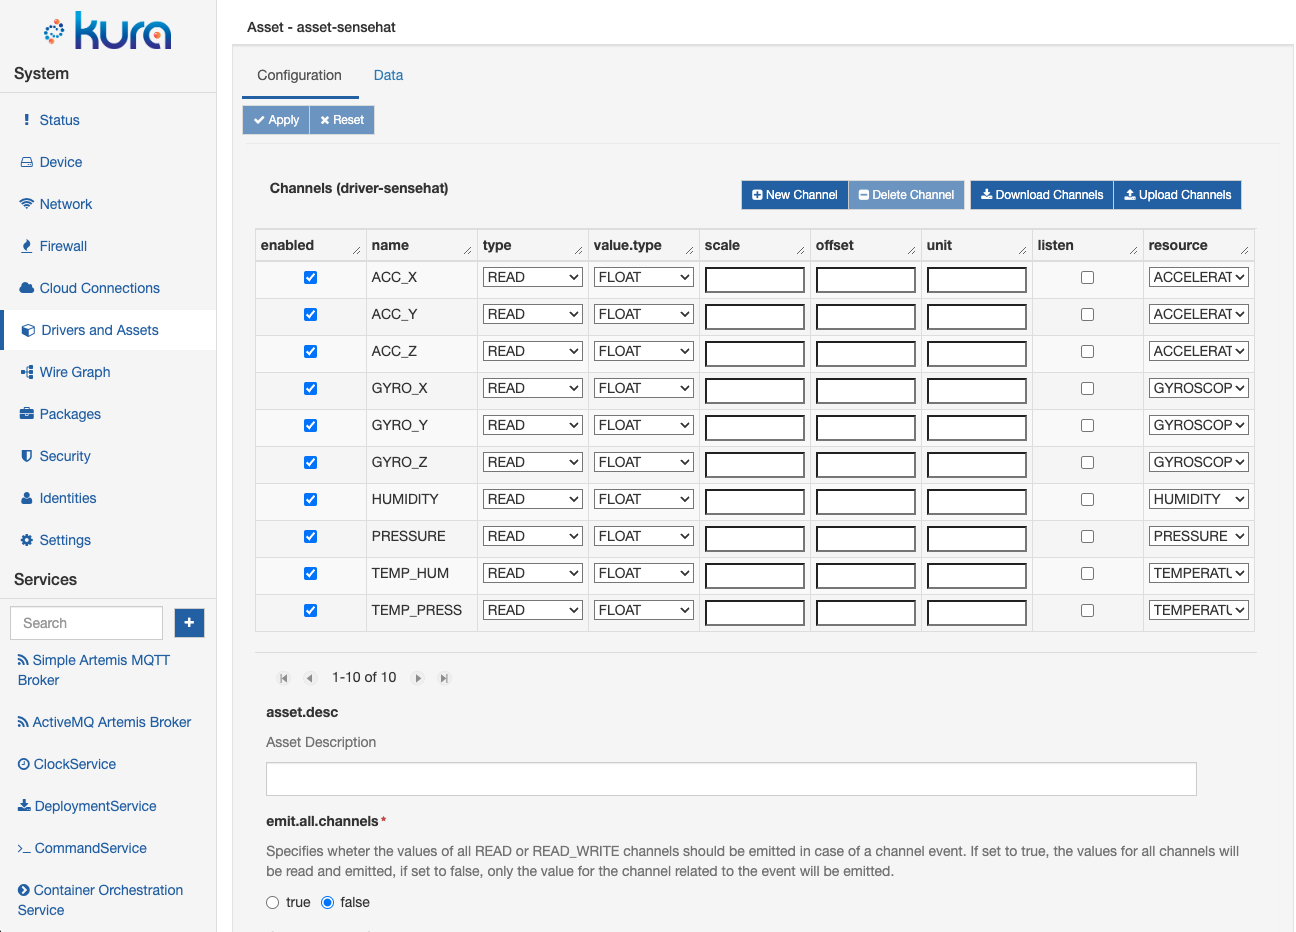

### Wire graph

Now that we have our driver and cloud publisher ready we can put everything together with a [Kura Wire Graph](https://eclipse.github.io/kura/docs-develop/kura-wires/introduction/).

Move to the "Wire Graph" section of the UI. We'll need a graph with three components:
- A `Timer` which will dictate the sample rate for our data collection
- A `WireAsset` for the SenseHat
- A `Publisher` for the Kapua publisher we created before.

The resulting Wire Graph will look like this:

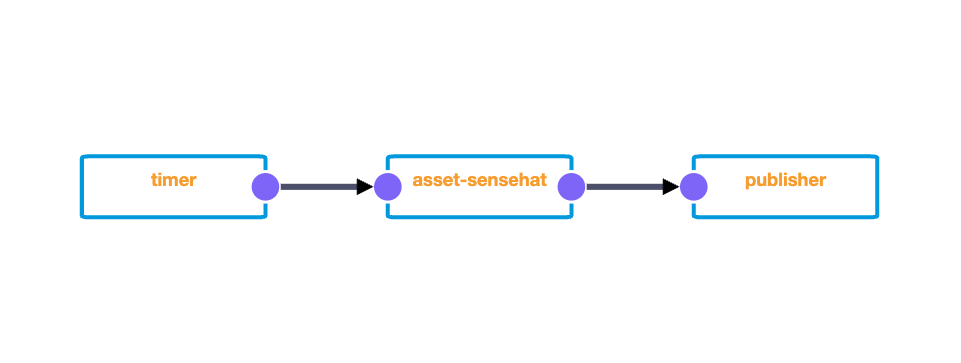

#### Timer

Configure the timer such that it will poll the SenseHat each second, this can be done by setting the `simple.interval` to `1`.

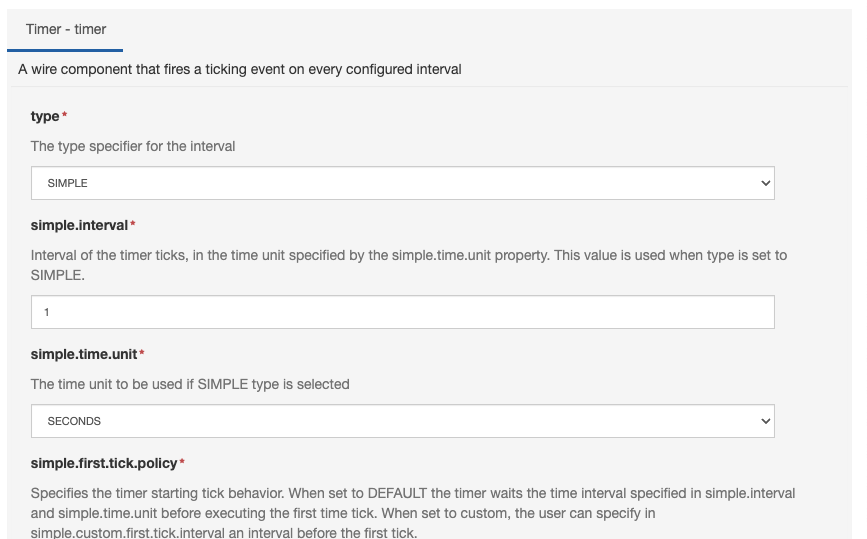

#### WireAsset

Select the `driver-sensehat` when creating the WireAsset. No further configuration is needed for this component.

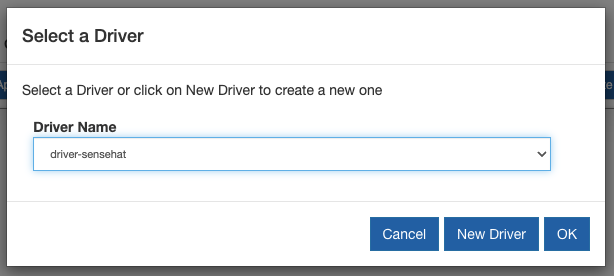

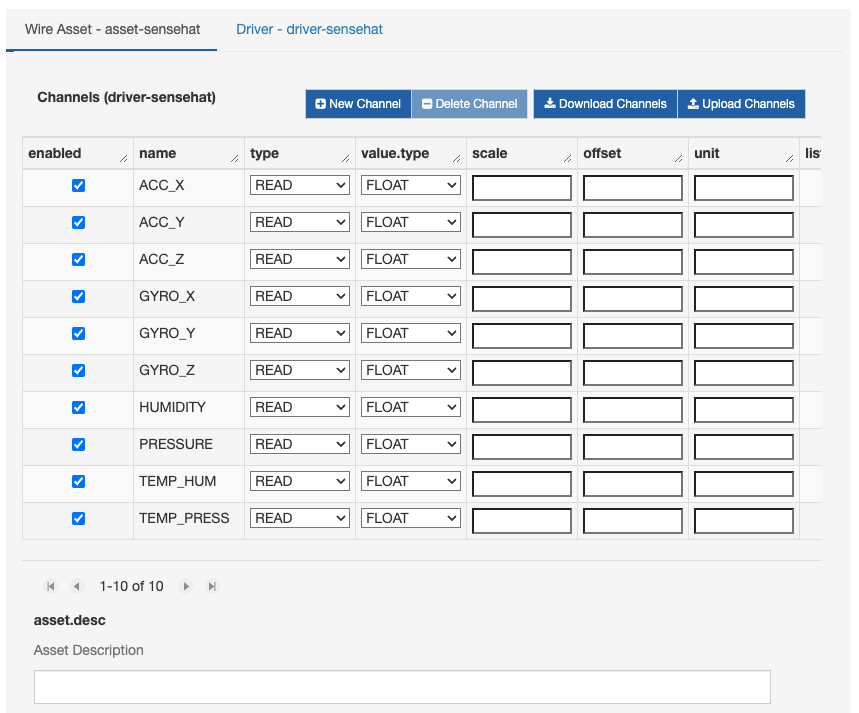

#### Publisher

Select the `KapuaSensehatPublisher` from the target filter.

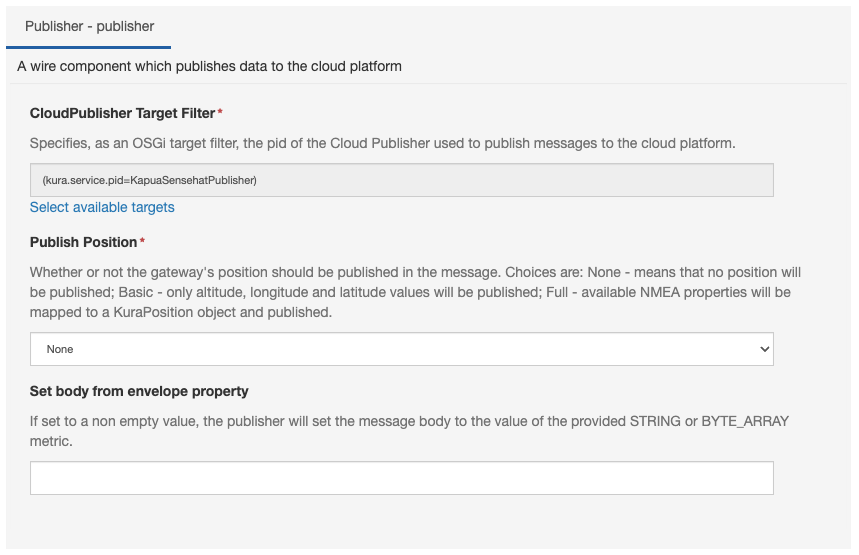

Don't forget to press "Apply" to start the Wire Graph!

### Collect the data

At this point you should see data coming from the Rasperry Pi from the Kapua&trade; console under the `SenseHat` topic.

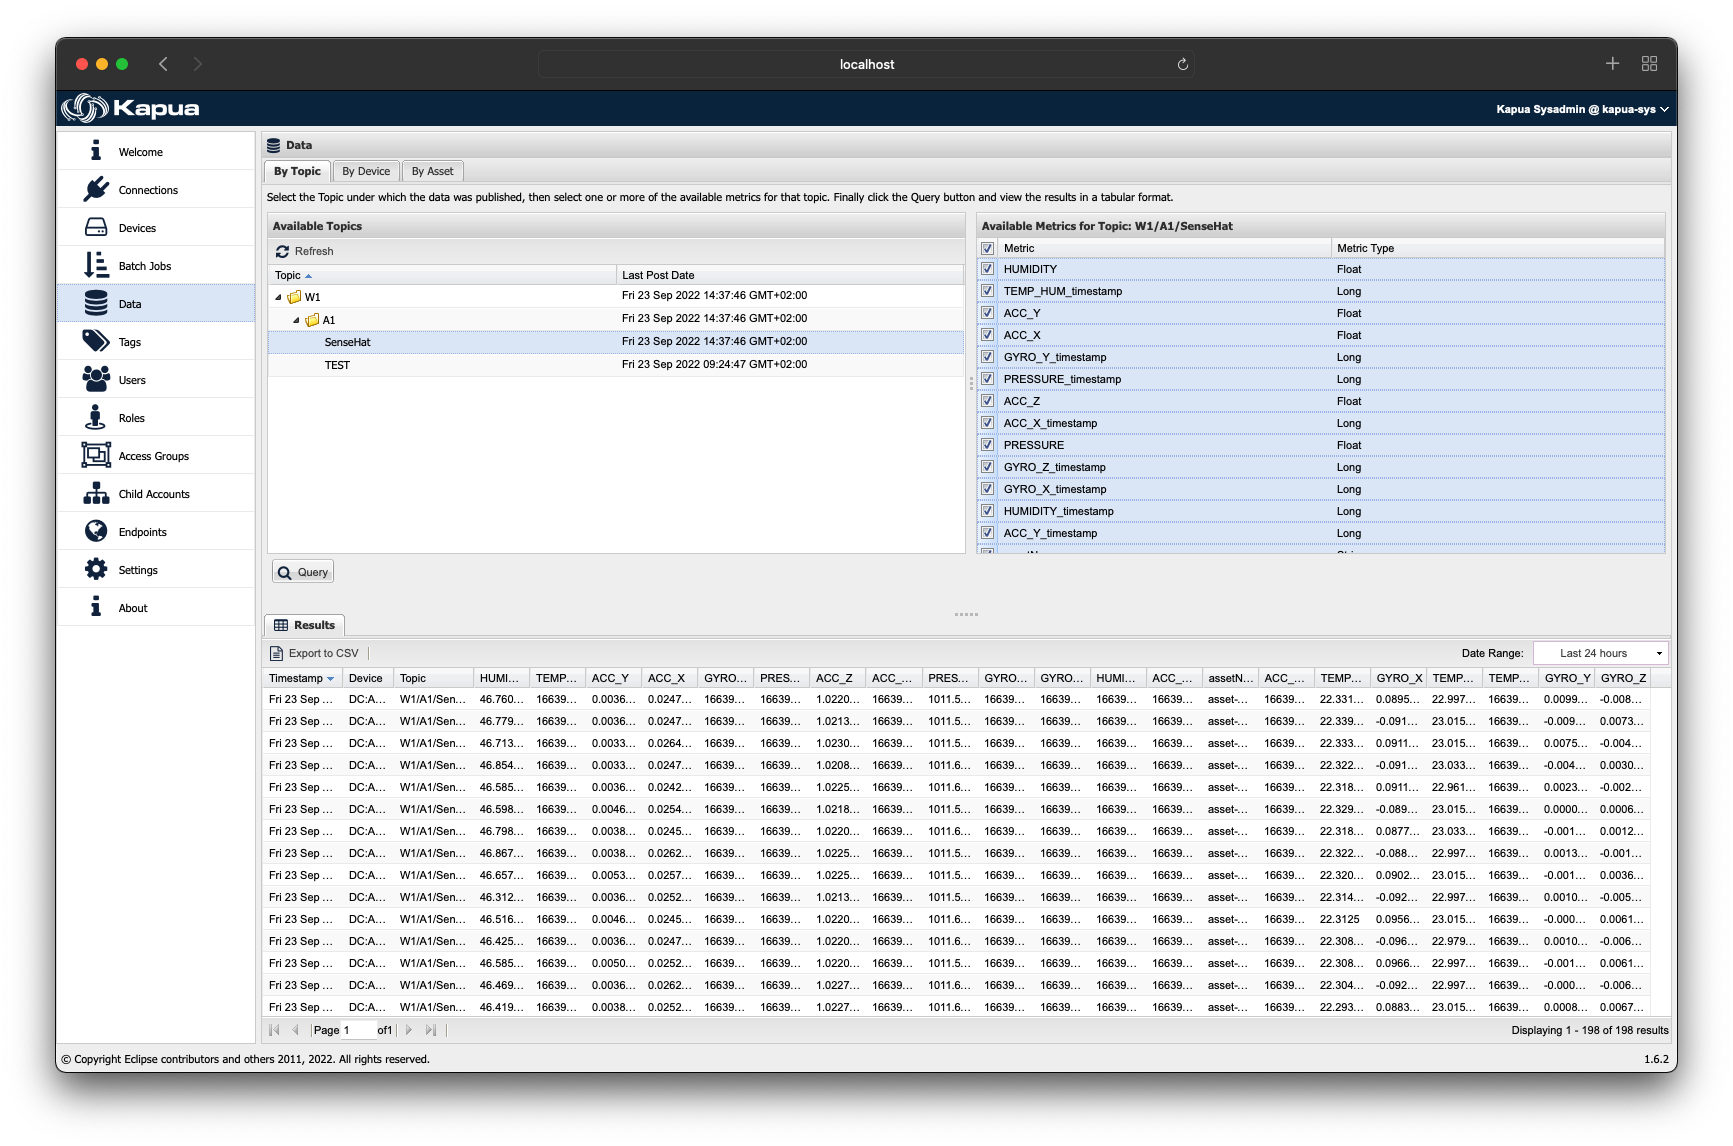

You can download the `.csv` file directly from the console using the "_Export to CSV_" button.

---

## Data Processing

We can now work on our `.csv` file downloaded from Kapua. For demonstration purposes an already available dataset is provided within this repository.

In [1]:
!ls *.csv

train-data-raw.csv


Let's start taking a look at the content of this dataset, we'll use [pandas](https://pandas.pydata.org/) (Python Data Analysis library) for this.

In [2]:
import pandas as pd

raw_data = pd.read_csv("./train-data-raw.csv")

raw_data.head()

,ID,TIMESTAMP,MAGNET_X,TEMP_HUM_timestamp,MAGNET_Z,MAGNET_Y,ACC_Y,ACC_X,GYRO_Y_timestamp,ACC_Z,...,PRESSURE_timestamp,MAGNET_X_timestamp,ACC_X_timestamp,GYRO_Z_timestamp,HUMIDITY_timestamp,assetName,ACC_Z_timestamp,GYRO_X,GYRO_Y,GYRO_Z
0,1,1645778791786,-2.680372,1645778791413,5.036951,8.646852,0.004364,0.080122,1645778791413,0.984048,...,1645778791413,1645778791413,1645778791413,1645778791413,1645778791413,asset-sensehat,1645778791413,0.053243,0.028920,0.036950
1,2,1645778792381,-3.110756,1645778792378,5.952562,10.521458,0.005091,0.080122,1645778792378,0.992090,...,1645778792378,1645778792378,1645778792378,1645778792378,1645778792378,asset-sensehat,1645778792378,-0.051105,-0.028920,-0.037256
2,3,1645778793412,-3.482263,1645778793408,6.719675,11.944528,0.005334,0.080122,1645778793408,0.986729,...,1645778793408,1645778793408,1645778793408,1645778793408,1645778793408,asset-sensehat,1645778793408,-0.025253,0.025560,0.038478
3,4,1645778794411,-3.813552,1645778794407,7.375115,13.093461,0.006061,0.080122,1645778794407,0.990384,...,1645778794407,1645778794407,1645778794407,1645778794407,1645778794407,asset-sensehat,1645778794407,0.100695,-0.023422,-0.037867
4,5,1645778795411,-4.050513,1645778795407,7.854155,14.029530,0.004849,0.080607,1645778795407,0.988922,...,1645778795407,1645778795407,1645778795407,1645778795407,1645778795407,asset-sensehat,1645778795407,-0.100389,0.021895,0.038172


### Feature selection

As you might notice there's some information in the dataset we don't care about and are not meaningful for our application:
- `ID`
- The various `timestamps`
- `assetName` which doesn't change

Then we can remove them from the dataset.

In [3]:
features = ['ACC_Y', 'ACC_X', 'ACC_Z',
            'PRESSURE', 'TEMP_PRESS', 'TEMP_HUM',
            'HUMIDITY', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']

data = raw_data[features]

data.head()

,ACC_Y,ACC_X,ACC_Z,PRESSURE,TEMP_PRESS,TEMP_HUM,HUMIDITY,GYRO_X,GYRO_Y,GYRO_Z
0,0.004364,0.080122,0.984048,992.322998,38.724998,40.330822,19.487146,0.053243,0.028920,0.036950
1,0.005091,0.080122,0.992090,992.288330,38.772915,40.385788,19.465750,-0.051105,-0.028920,-0.037256
2,0.005334,0.080122,0.986729,992.275635,38.795834,40.349144,19.572731,-0.025253,0.025560,0.038478
3,0.006061,0.080122,0.990384,992.279053,38.797916,40.330822,19.358767,0.100695,-0.023422,-0.037867
4,0.004849,0.080607,0.988922,992.333008,38.845833,40.385788,19.390862,-0.100389,0.021895,0.038172


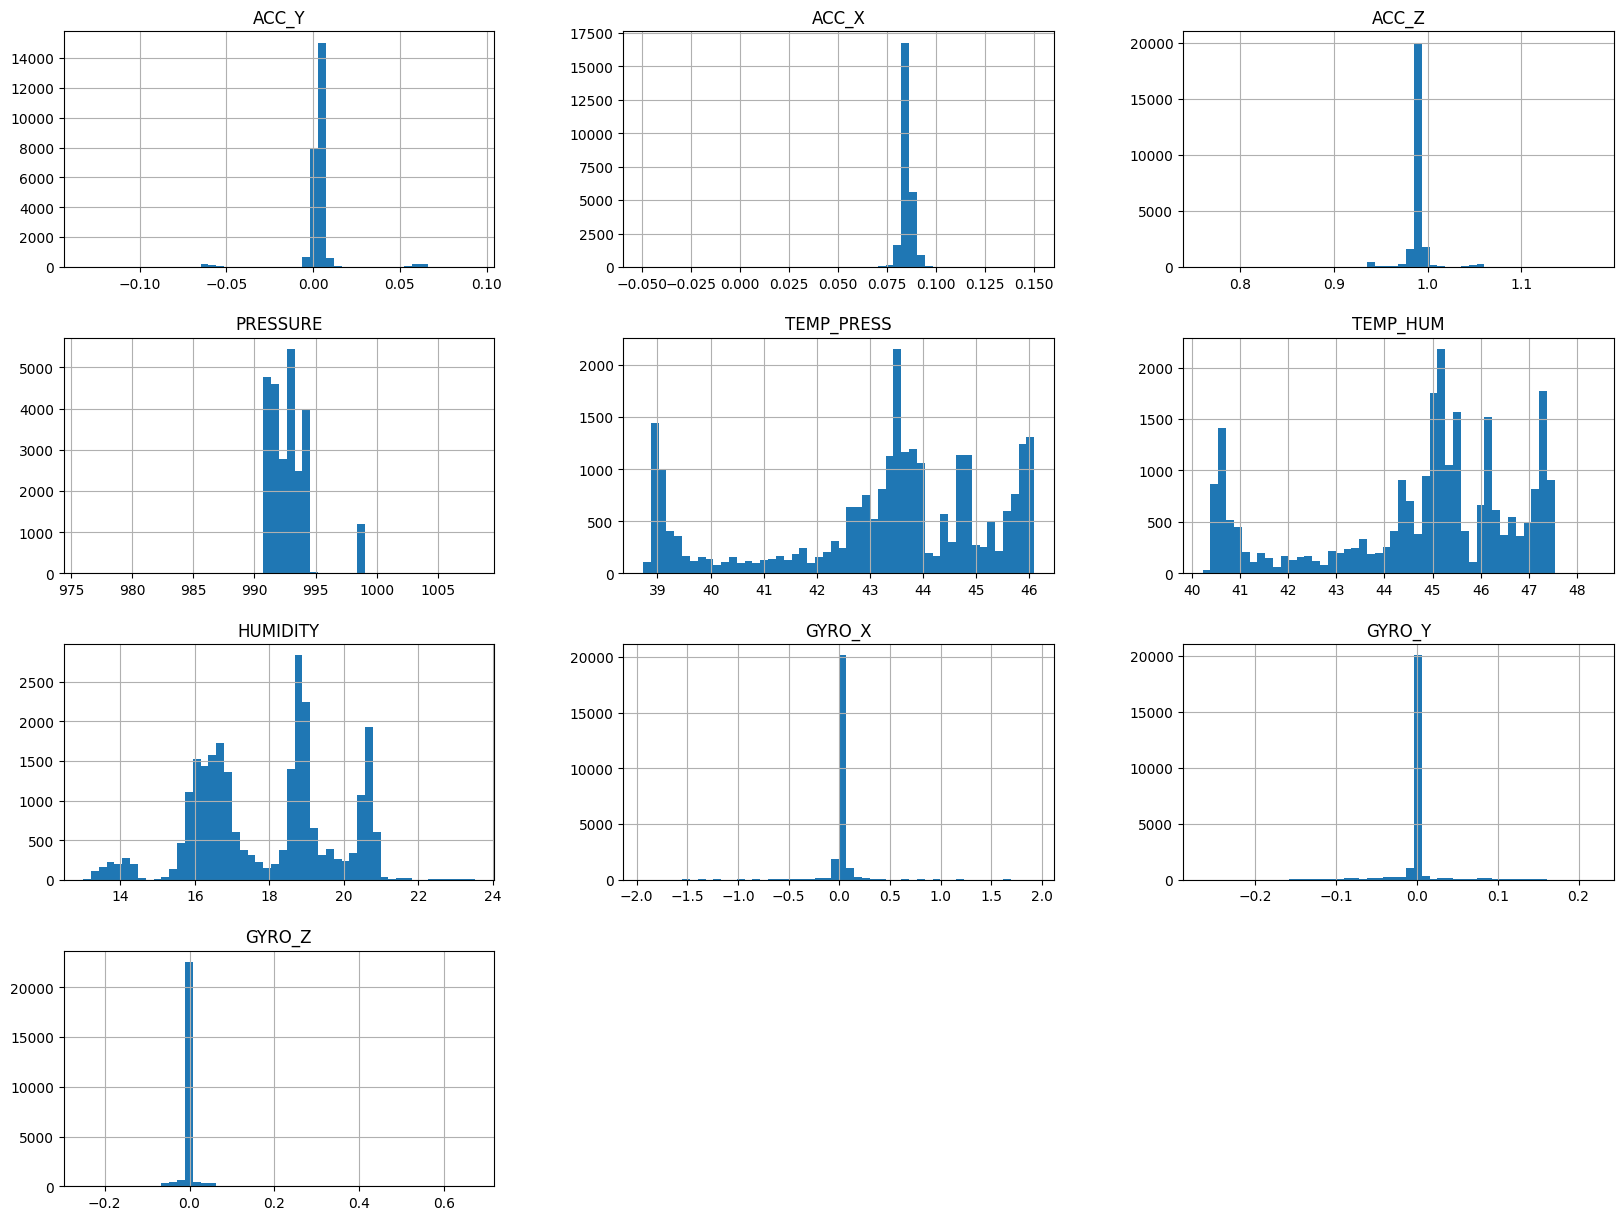

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

data.hist(bins=50, figsize=(20,15))
plt.show()

### Feature scaling

AI models don't perform well when the input numerical attributes have very different scales. As you can see `ACC_X`, `ACC_Y` and `ACC_Z` range from 0 to 1, while the `PRESSURE` have far higher values.

There are two common ways to address this: _normalization_ and _standardization_.

_Normalization_ (a.k.a. Min-max scaling) shifts and rescales values so that they end up ranging from 0 to 1. This can be done by subtracting the min value and dividing by the max minus the min.

x' = $\frac{x - min(x)}{max(x) - min(x)}$

_Standardization_ makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation.

x' = $\frac{x - avg(x)}{\sigma}$

Fortunately for us [scikit-learn](https://scikit-learn.org/stable/) library provides a function for both of them. In this case we'll use _normalization_ because it works well for this application.

In [5]:
print("Data used in the Triton preprocessor")
print("-----------Min-----------")
print(data.min())
print("-----------Max-----------")
print(data.max())
print("-------------------------")

Data used in the Triton preprocessor
-----------Min-----------
ACC_Y          -0.132551
ACC_X          -0.049693
ACC_Z           0.759847
PRESSURE      976.001709
TEMP_PRESS     38.724998
TEMP_HUM       40.220890
HUMIDITY       13.003981
GYRO_X         -1.937896
GYRO_Y         -0.265019
GYRO_Z         -0.250647
dtype: float64
-----------Max-----------
ACC_Y            0.093099
ACC_X            0.150289
ACC_Z            1.177543
PRESSURE      1007.996338
TEMP_PRESS      46.093750
TEMP_HUM        48.355824
HUMIDITY        23.506138
GYRO_X           1.923712
GYRO_Y           0.219204
GYRO_Z           0.671759
dtype: float64
-------------------------


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.to_numpy())

In [7]:
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000
mean,0.603124,0.674196,0.550454,0.526446,0.605576,0.552252,0.466400,0.501160,0.545457,0.271295
std,0.049333,0.015135,0.031627,0.054050,0.288300,0.256587,0.176293,0.062908,0.067678,0.014665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.597087,0.667343,0.544924,0.481917,0.501060,0.441442,0.325637,0.501348,0.544670,0.270709
50%,0.603534,0.673413,0.551342,0.521377,0.655357,0.608108,0.511715,0.501841,0.547096,0.271685
75%,0.611055,0.680698,0.555426,0.552892,0.819339,0.734234,0.575212,0.502407,0.549386,0.272577
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Train test split

The only way to know how well a model will generalize to new data points is to try it on new data. To do so we split our data into two sets: the training set and the test set.

To do so we'll use a function from `scikit-learn`.

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test = train_test_split(scaled_data, test_size=0.3, random_state=42)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

---

## Model training

We can now leverage the [Keras](https://keras.io/) API of [Tensorflow](https://www.tensorflow.org/) for creating our Autoencoder and then train it on our dataset.

### Create the Autoencoder model

In this example we'll use a basic fully-connected autoencoder.

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Avoid AVX2 error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_model(input_dim):
    # Latent space dimension
    latent_dim = 4

    # The encoder will consist of a number of dense layers that decrease in size
    # as we taper down towards the bottleneck of the network, the latent space
    input_data = Input(shape=(input_dim,), name='INPUT0')

    # hidden layers
    encoder = Dense(24, activation='tanh', name='encoder_1')(input_data)
    encoder = Dropout(.15)(encoder)
    encoder = Dense(16, activation='tanh', name='encoder_2')(encoder)
    encoder = Dropout(.15)(encoder)

    # bottleneck layer
    latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

    # The decoder network is a mirror image of the encoder network
    decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
    decoder = Dropout(.15)(decoder)
    decoder = Dense(24, activation='tanh', name='decoder_2')(decoder)
    decoder = Dropout(.15)(decoder)

    # The output is the same dimension as the input data we are reconstructing
    reconstructed_data = Dense(input_dim, activation='linear', name='OUTPUT0')(decoder)

    autoencoder_model = Model(input_data, reconstructed_data)

    return autoencoder_model

In [10]:
autoencoder_model = create_model(len(features))
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT0 (InputLayer)         [(None, 10)]              0         
                                                                 
 encoder_1 (Dense)           (None, 24)                264       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 encoder_2 (Dense)           (None, 16)                400       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 latent_encoding (Dense)     (None, 4)                 68        
                                                                 
 decoder_1 (Dense)           (None, 16)                80    

### Model training

As we already explained in the presentation, the autoencoder is a  type of artificial neural network used to learn efficient codings of unlabeled data. We'll use that to reconstruct the input at the output. Being trained on the "normal" data of the system, it won't be able to reconstruct correctly "anomalous" data and thus will work as an anomaly detector.

Our loss function, which we need to minimize during our training, is the error between the _input data_ and the _data reconstructed by the autoencoder_. We'll use the mean squared error.

In [11]:
from tensorflow.keras import optimizers

batch_size = 64
max_epochs = 10
learning_rate = .0001

opt = optimizers.Adam(learning_rate=learning_rate)
autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
autoencoder_model.fit(x_train, x_train,
                      shuffle=True,
                      epochs=max_epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test))

Epoch 1/10
277/277 [==============================] - 1s 2ms/step - loss: 0.2532 - accuracy: 0.0719 - val_loss: 0.0880 - val_accuracy: 0.0083
Epoch 2/10
277/277 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.1364 - val_loss: 0.0209 - val_accuracy: 0.6835
Epoch 3/10
277/277 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.2062 - val_loss: 0.0140 - val_accuracy: 0.6747
Epoch 4/10
277/277 [==============================] - 0s 1ms/step - loss: 0.0451 - accuracy: 0.2537 - val_loss: 0.0100 - val_accuracy: 0.6690
Epoch 5/10
277/277 [==============================] - 0s 1ms/step - loss: 0.0353 - accuracy: 0.3121 - val_loss: 0.0073 - val_accuracy: 0.6763
Epoch 6/10
277/277 [==============================] - 0s 1ms/step - loss: 0.0282 - accuracy: 0.3544 - val_loss: 0.0056 - val_accuracy: 0.6776
Epoch 7/10
277/277 [==============================] - 0s 1ms/step - loss: 0.0229 - accuracy: 0.4012 - val_loss: 0.0046 - val_accuracy: 0.7679
Epoch 

We can save the model on disk as we'll use this later.

In [12]:
autoencoder_model.save("./saved_model/autoencoder")

INFO:tensorflow:Assets written to: ./saved_model/autoencoder/assets


INFO:tensorflow:Assets written to: ./saved_model/autoencoder/assets


In [13]:
!ls ./saved_model/autoencoder

assets            keras_metadata.pb saved_model.pb    variables


---

## Model evaluation

We now have a model that reconstruct the input at the output... doesn't sounds really useful right?

Let's see it in action. Let's take a sample from the test set and run it through our autoencoder.

In [14]:
input_sample = x_test[3:4].copy() # Deep copy

reconstructed_sample = autoencoder_model.predict(input_sample)

print(input_sample)
print(reconstructed_sample)

1/1 [==============================] - 0s 110ms/step
[[0.603534   0.6770555  0.54900813 0.5327966  0.6680801  0.6171171
  0.5198642  0.50135666 0.54716927 0.2718224 ]]
[[0.5912146  0.6508939  0.5364153  0.512447   0.62290615 0.5733185
  0.44161606 0.48225182 0.51420563 0.2694023 ]]


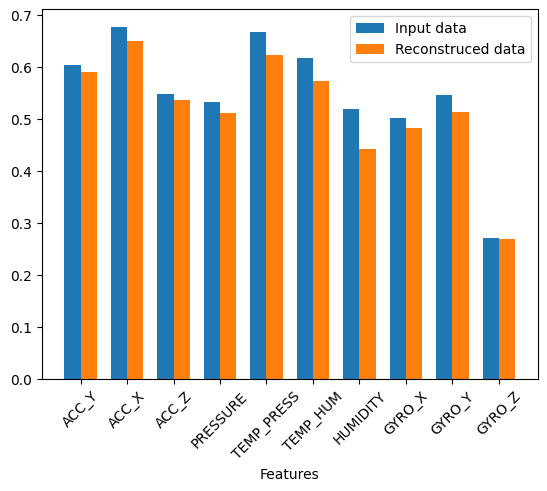

In [15]:
import matplotlib.pyplot as plt

index = np.arange(10)
bar_width = 0.35

figure, ax = plt.subplots()

inbar = ax.bar(index, input_sample[0], bar_width, label="Input data")
recbar = ax.bar(index+bar_width, reconstructed_sample[0], bar_width, label="Reconstruced data")

ax.set_xlabel('Features')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features, rotation = 45)
ax.legend()

What happens if we manipulate this sample in a way the autoencoder doesn't expect?

Let's try and set the `ACC_Z` to a value the autoencoder has never seen before.

In [16]:
input_anomaly = input_sample.copy() # Deep copy

input_anomaly[0][2] = 0.15

reconstructed_anomaly = autoencoder_model.predict(input_anomaly)

print(input_anomaly)
print(reconstructed_anomaly)

1/1 [==============================] - 0s 21ms/step
[[0.603534   0.6770555  0.15       0.5327966  0.6680801  0.6171171
  0.5198642  0.50135666 0.54716927 0.2718224 ]]
[[0.60400957 0.60066587 0.49978355 0.45874017 0.765943   0.68019176
  0.37265062 0.48134157 0.4920761  0.26122886]]


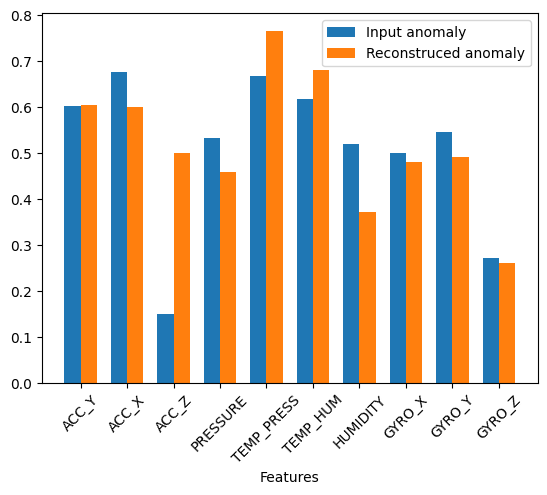

In [17]:
figure, ax = plt.subplots()

inbar = ax.bar(index, input_anomaly[0], bar_width, label="Input anomaly")
recbar = ax.bar(index+bar_width, reconstructed_anomaly[0], bar_width, label="Reconstruced anomaly")

ax.set_xlabel('Features')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features, rotation = 45)
ax.legend()

The autoencoder fails to reconstruct the data it received at the input. This means that the reconstruction error is very high.

In [18]:
from sklearn.metrics import mean_squared_error

print("Anomaly %f.6"% mean_squared_error(input_anomaly[0], reconstructed_anomaly[0]))
print("Normal  %f.6"% mean_squared_error(input_sample[0], reconstructed_sample[0]))

Anomaly 0.017244.6
Normal  0.001295.6


It's working as expected!

We now need to decide when to trigger an alarm (i.e. classify an input sample as anomalous) from this data. A common strategy is to comput the max value of the reconstruction error in the test set and set a threshold based on this value.

In [19]:
x_test_recon = autoencoder_model.predict(x_test)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)  # MSE

anomaly_data = pd.DataFrame({'recon_score': reconstruction_scores})
print(anomaly_data.describe())

237/237 [==============================] - 0s 664us/step
       recon_score
count  7584.000000
mean      0.003391
std       0.004530
min       0.000284
25%       0.001254
50%       0.001861
75%       0.002760
max       0.093613


In [20]:
alpha = 1.5
threshold = np.max(reconstruction_scores) * alpha
print("Anomaly score threshold: %f" % threshold)

Anomaly score threshold: 0.140420


We now have our anomaly detector, we need to deploy it on our Kura device.

---

## Model deployment

To deploy our model on the target device we'll leverage Kura&trade;'s newly added [Nvidia&trade; Triton Inferece Server](https://developer.nvidia.com/nvidia-triton-inference-server) integration.

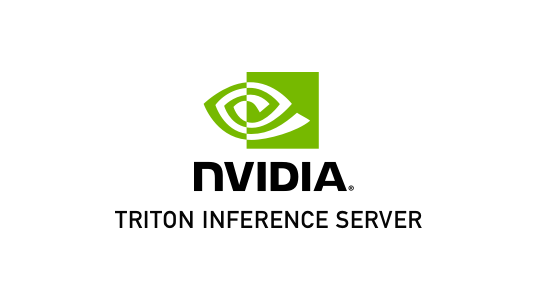

The Nvidia™ Triton Inference Server is an open-source inference service software that enables the user to deploy trained AI models from any framework on GPU or CPU infrastructure. It supports all major frameworks like TensorFlow, TensorRT, PyTorch, ONNX Runtime, and even custom framework backend. With specific backends, it is also possible to run Python scripts, mainly for pre-and post-processing purposes, and exploit the DALI building block for optimized operations.

For installation refer to the official [Kura&trade;](https://eclipse.github.io/kura/docs-develop/core-services/nvidia-triton-server-inference-engine/#nvidiatm-triton-server-installation) and [Triton documentation](https://github.com/triton-inference-server/server/tree/main/docs#installation). For the rest of this tutorial we'll assume a Triton container is available on the target device.

We'll also need to install Kura&trade;'s Triton bundles:
- [Triton Server Component](https://marketplace.eclipse.org/content/triton-server-component-eclipse-kura-5): for Kura-Triton integration
- [AI Wire Component](https://marketplace.eclipse.org/content/ai-wire-component-eclipse-kura-5): for making the Triton Inference Server available through the Kura Wires.

### Model conversion

The first step in using Triton to serve your models is to place one or more models into a [model repository](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md) i.e. a folder were the model are available for Triton to load. Depending on the type of the model and on what Triton capabilities you want to enable for the model, you may need to create a [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md) for the model which is a protobuf containing informations about runtime configuration and input/output shape accepted by the model.

For our autoencoder model we'll need three "models":
- A **Preprocessor** for performing the operations described in the ["Data processing"](#Data-Processing) section (Wire envelop translation, feature selection and scaling)
- The **Autoencoder** model we exported in the ["Model training"](#Model-training) section
- A **Postprocessor** for performing the operations described in the ["Model evaluation"](#Model-evaluation) section (Reconstruction error computation)

To simplify the handling of these models we'll use an advanced feature of Triton wich is an [Ensemble Model](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/architecture.md#ensemble-models).

From Triton official documentation:

> An ensemble model represents a pipeline of one or more models and the connection of input and output tensors between those models. Ensemble models are intended to be used to encapsulate a procedure that involves multiple models, such as "data preprocessing -> inference -> data postprocessing". Using ensemble models for this purpose can avoid the overhead of transferring intermediate tensors and minimize the number of requests that must be sent to Triton.

#### Autoencoder

As seen in the ["Model training"](#Model-training) section, our model is available as a [Tensorflow _SavedModel](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md#tensorflow-models)_ which can be simply loaded by the Triton [Tensorflow backend](https://github.com/triton-inference-server/tensorflow_backend). We just need to configure it properly.

We'll start by creating the following folder structure

```
tf_autoencoder_fp32
├── 1
│   └── model.savedmodel
│       ├── assets
│       ├── keras_metadata.pb
│       ├── saved_model.pb
│       └── variables
│           ├── variables.data-00000-of-00001
│           └── variables.index
└── config.pbtxt
```

This can be done by copying the model we saved in the Model Training section:

```bash
mkdir -p path/to/tf_autoencoder_fp32/1
```

```bash
cp -r ./saved_model/autoencoder path/to/tf_autoencoder_fp32/1/model.savedmodel
```

Now comes the hard part: we need to provide the [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md) (i.e. the `config.pbtxt` file). In the case of the autoencoder is pretty simple:

```protobuf
name: "tf_autoencoder_fp32"
backend: "tensorflow"
max_batch_size: 0
input [
    {
    name: "INPUT0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
    }
]
output [
    {
    name: "OUTPUT0"
    data_type: TYPE_FP32
    dims: [ -1, 10 ]
    }
]
version_policy: { all { }}
```

Each model `input` and `output` must specify the `name`, `data_type` and `dims`. We already know all of these:
- `name`: corresponds to the layer name we've seen in the Model Training section. `INPUT0` for the input and `OUTPUT0` for the output.
- `data_type`: will be float since we didn't perform any quantization
- `dims`: is the shape of the in/out tensor. In this case it will correspond to an array with the same length as the number of features.

Other interesting parameters of this configuration are:
- `backend`: where we set the backend for the model. In this case it will be the Tensorflow backend
- `name`: the name of the model that must correspond to the name of the folder

for a deep dive into the model configuration parameter take a look at the [official documentation](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md).

#### Preprocessor

As discussed in the ["Data processing"](#Data-Processing) section, before providing the incoming data to the autoencoder, we need to perform feature selection and scaling. In addition to these responsibilites, the Preprocessor will need to perform a sort of serialization of the data to comply to the input shape accepted by the Autoencoder. This is due to how Kura manages the data running on Wires. More details can be found [here](https://eclipse.github.io/kura/docs-develop/kura-wires/single-port-wire-components/ai-wire-component/#models-input-and-output-formats).

To perform all of this we'll use the [Python backend](https://github.com/triton-inference-server/python_backend) available in Triton.

As described in the previous section we will need to provide the following folder structure:

```
preprocessor
├── 1
│   └── model.py
└── config.pbtxt
```

##### Preprocessor Configuration

As discussed in the [official Kura documentation](https://eclipse.github.io/kura/docs-develop/kura-wires/single-port-wire-components/ai-wire-component/#models-input-and-output-formats):

> The AI wire component takes a WireEnvelope as an input, it processes its records and feeds them to the specified preprocessing or inference model.
>
> ...
>
> The models that manage the input and the output must expect a list of inputs such that:
> - each input corresponds to an entry of the `WireRecord` properties
> - the entry key will become the input name (e.g. in the case of an asset, the channel name becomes the tensor name)
> - input shape will be `[1]`

Therefore for our `input` we'll have that each name corresponds to the names we've seen in the Data Collection section. The `output` needs to correspond to the input accepted by the model (i.e. `INPUT0`).

```protobuf
name: "preprocessor"
backend: "python"

input [
  {
    name: "ACC_X"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
input [
  {
    name: "ACC_Y"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
 ...
input [
  {
    name: "TEMP_PRESS"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "INPUT0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
  }
]
instance_group [{ kind: KIND_CPU }]
```

##### Preprocessor Model

As we've seen in the Data Processing section the Preprocessor is responsible for scaling the input features and serializing them in the tensor shape expected by the Autoencoder model.

This can be done with the following python script:

```python
import numpy as np
import json

import triton_python_backend_utils as pb_utils


class TritonPythonModel:

    def initialize(self, args):
        self.model_config = model_config = json.loads(args['model_config'])

        output0_config = pb_utils.get_output_config_by_name(
            model_config, "INPUT0")

        self.output0_dtype = pb_utils.triton_string_to_numpy(
            output0_config['data_type'])

    def execute(self, requests):
        output0_dtype = self.output0_dtype

        responses = []

        for request in requests:
            acc_x      = pb_utils.get_input_tensor_by_name(request, "ACC_X").as_numpy()
            acc_y      = pb_utils.get_input_tensor_by_name(request, "ACC_Y").as_numpy()
            acc_z      = pb_utils.get_input_tensor_by_name(request, "ACC_Z").as_numpy()
            gyro_x     = pb_utils.get_input_tensor_by_name(request, "GYRO_X").as_numpy()
            gyro_y     = pb_utils.get_input_tensor_by_name(request, "GYRO_Y").as_numpy()
            gyro_z     = pb_utils.get_input_tensor_by_name(request, "GYRO_Z").as_numpy()
            humidity   = pb_utils.get_input_tensor_by_name(request, "HUMIDITY").as_numpy()
            pressure   = pb_utils.get_input_tensor_by_name(request, "PRESSURE").as_numpy()
            temp_hum   = pb_utils.get_input_tensor_by_name(request, "TEMP_HUM").as_numpy()
            temp_press = pb_utils.get_input_tensor_by_name(request, "TEMP_PRESS").as_numpy()

            out_0 = np.array([acc_y, acc_x, acc_z, pressure, temp_press, temp_hum, humidity, gyro_x, gyro_y, gyro_z]).transpose()

            #                  ACC_Y     ACC_X     ACC_Z    PRESSURE   TEMP_PRESS   TEMP_HUM   HUMIDITY    GYRO_X    GYRO_Y    GYRO_Z
            min = np.array([-0.132551, -0.049693, 0.759847, 976.001709, 38.724998, 40.220890, 13.003981, -1.937896, -0.265019, -0.250647])
            max = np.array([ 0.093099, 0.150289, 1.177543, 1007.996338, 46.093750, 48.355824, 23.506138, 1.923712, 0.219204, 0.671759])

            # MinMax scaling
            out_0_scaled = (out_0 - min)/(max - min)

            # Create output tensor
            out_tensor_0 = pb_utils.Tensor("INPUT0",
                                           out_0_scaled.astype(output0_dtype))

            inference_response = pb_utils.InferenceResponse(
                output_tensors=[out_tensor_0])
            responses.append(inference_response)

        return responses
```

Here there are two important things to note:
- The template we're using is taken from the Triton documentation and can be found [here](https://github.com/triton-inference-server/python_backend/blob/main/examples/add_sub/model.py).
- The MinMax scaling **must be the same we used in our training**. For illustration purposes we wrote the `min` and `max` arrays we found in the Data Processing section but we could have serialized the `MinMaxScaler` using [`pickle`](https://docs.python.org/3/library/pickle.html) instead.

#### Postprocessor

As discussed in the ["Data processing"](#Data-Processing) section, to perform the anomaly detection step we need to compute the Mean Squared Error between the recontructed data and the actual input data. Due to this the configuration of the Postprocessor model will be somewhat more complicated than before: in addition to the output of the Autoencoder model we will need the output of the Preprocessor model.

To perform all of this we'll use the [Python backend](https://github.com/triton-inference-server/python_backend) again.

As described in the previous section we will need to provide the following folder structure:

```
postprocessor
├── 1
│   └── model.py
└── config.pbtxt
```

##### Postprocessor Configuration

```protobuf
name: "postprocessor"
backend: "python"

input [
  {
    name: "RECONSTR0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
  }
]
input [
  {
    name: "ORIG0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
  }
]
output [
  {
    name: "ANOMALY_SCORE0"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "ANOMALY0"
    data_type: TYPE_BOOL
    dims: [ 1 ]
  }
]
instance_group [{ kind: KIND_CPU }]
```

As we can see we have two inputs and two outputs:
- The first input tensor is the reconstruction performed by the autoencoder model
- The second input tensor is the original data (already scaled and serialized by the Preprocessor model)
- The first output is the anomaly score i.e. the reconstruction error between the original and the reconstructed data.
- The second output is a boolean representing whether the data constitute an anomaly or not

Let's see how this is computed by the Python model.

##### Postprocessor Model

```python
import numpy as np
import json

import triton_python_backend_utils as pb_utils


class TritonPythonModel:

    def initialize(self, args):
        self.model_config = model_config = json.loads(args['model_config'])

        output0_config = pb_utils.get_output_config_by_name(
            model_config, "ANOMALY_SCORE0")
        output1_config = pb_utils.get_output_config_by_name(
            model_config, "ANOMALY0")

        self.output0_dtype = pb_utils.triton_string_to_numpy(
            output0_config['data_type'])
        self.output1_dtype = pb_utils.triton_string_to_numpy(
            output1_config['data_type'])

    def execute(self, requests):
        output0_dtype = self.output0_dtype
        output1_dtype = self.output1_dtype

        responses = []

        for request in requests:
            THRESHOLD = 0.16

            # Get input
            x_recon = pb_utils.get_input_tensor_by_name(request, "RECONSTR0").as_numpy()
            x_orig = pb_utils.get_input_tensor_by_name(request, "ORIG0").as_numpy()

            # Get Mean square error between reconstructed input and original input
            reconstruction_score = np.mean((x_orig - x_recon)**2, axis=1)

            anomaly = reconstruction_score > THRESHOLD

            # Create output tensors
            out_tensor_0 = pb_utils.Tensor("ANOMALY_SCORE0",
                                           reconstruction_score.astype(output0_dtype))
            out_tensor_1 = pb_utils.Tensor("ANOMALY0",
                                           anomaly.astype(output1_dtype))

            inference_response = pb_utils.InferenceResponse(
                output_tensors=[out_tensor_0, out_tensor_1])
            responses.append(inference_response)

        return responses
```

As you can see the script is simple:
- It gets the input tensors
- It computes the Mean Squared Error between the inputs (which is what we called the reconstruction error)
- Using the `THRESHOLD` we computed in the Model Training section, it decides whether the input data is an anomaly or not

### Ensemble model

To make things easier for ourselves and improve performance we'll consolidate the AI pipeline into an [Ensemble Model](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/architecture.md#ensemble-models).

We will need to provide the following folder structure:

```
ensemble_pipeline
├── 1
└── config.pbtxt
```

Note that the `1` folder is **empty**. The ensemble model essentially describe *how to connect the models that belong to the processing pipeline*.

Therefore we'll need to focus on the configuration only.

```protobuf
name: "ensemble_pipeline"
platform: "ensemble"
max_batch_size: 0
input [
  {
    name: "ACC_X"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
input [
  {
    name: "ACC_Y"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
 ...
input [
  {
    name: "TEMP_PRESS"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "ANOMALY_SCORE0"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "ANOMALY0"
    data_type: TYPE_BOOL
    dims: [ 1 ]
  }
]
ensemble_scheduling {
  step [
    {
      model_name: "preprocessor"
      model_version: -1
      input_map{
          key: "ACC_X"
          value: "ACC_X"
      }
      input_map{
          key: "ACC_Y"
          value: "ACC_Y"
      }
       ...
      input_map{
          key: "TEMP_PRESS"
          value: "TEMP_PRESS"
      }
      output_map {
        key: "INPUT0"
        value: "preprocess_out"
      }
    },
    {
      model_name: "tf_autoencoder_fp32"
      model_version: -1
      input_map {
        key: "INPUT0"
        value: "preprocess_out"
      }
      output_map {
        key: "OUTPUT0"
        value: "autoencoder_output"
      }
    },
    {
      model_name: "postprocessor"
      model_version: -1
      input_map {
        key: "RECONSTR0"
        value: "autoencoder_output"
      }
      input_map {
        key: "ORIG0"
        value: "preprocess_out"
      }
      output_map {
        key: "ANOMALY_SCORE0"
        value: "ANOMALY_SCORE0"
      }
      output_map {
        key: "ANOMALY0"
        value: "ANOMALY0"
      }
    }
  ]
}
```

The configuration is split in two main parts:
- The first is the usual configuration we've seen before: we describe what are the input and the output of our model. In this case the input will correspond to the input of the first model of the pipeline (the Preprocessor) and the output to the output of the last model of the pipeline (the Postprocessor)
- The second part describe how to map the input/output of the models within the pipeline

To better visualize the configuration we can look at the graph below.

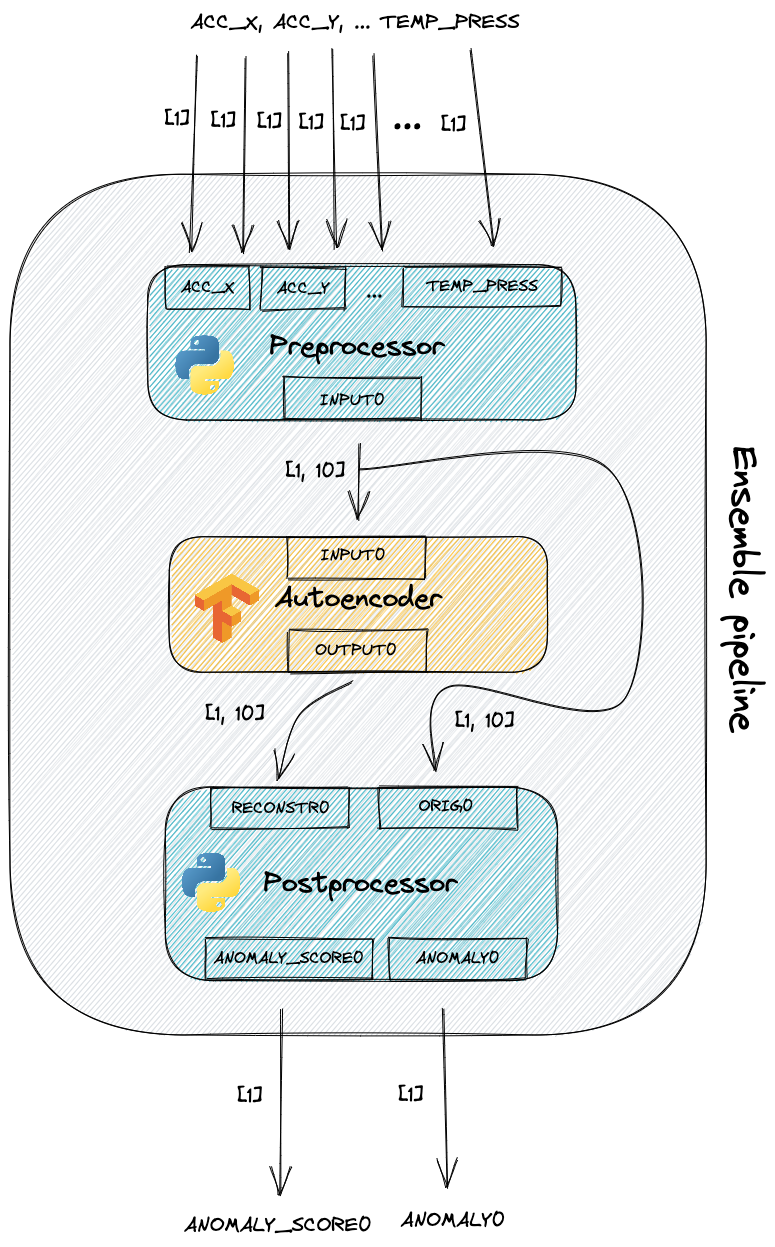